In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [3]:
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/product_analytics/RFM_ht_data.csv')

In [4]:
orders.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [5]:
orders.shape[0]

332730

In [6]:
orders.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

Видно, что питон некорректно прочитал типы данных (object). Зададим типы явно.

In [7]:
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])

In [8]:
orders['CustomerCode'] = orders['CustomerCode'].apply(str)

In [9]:
orders.InvoiceDate.describe()

count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

#### 1. RFM-анализ

In [10]:
last_date = orders['InvoiceDate'].max()

In [11]:
last_date

Timestamp('2020-09-30 00:00:00')

In [12]:
rfm =orders.groupby('CustomerCode')\
            .agg({'InvoiceDate':lambda x: (last_date-x.max()).days,
                  'InvoiceNo':lambda x: len(x), 
                  'Amount':lambda x: x.sum()})

In [13]:
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm = rfm.rename(columns={'InvoiceDate': 'R', 'InvoiceNo': 'F', 'Amount': 'M'})

In [14]:
rfm

,R,F,M
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [15]:
orders.CustomerCode.nunique()

123733

In [16]:
quantiles=rfm.quantile(q=([.25, .5, .75]))
quantiles

,R,F,M
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [17]:
def r_score(x):
    if x <= quantiles['R'][.25]:
        return 1
    elif x <= quantiles['R'][.5]:
        return 2
    elif x <= quantiles['R'][.75]:
        return 3
    else:
        return 4

In [18]:
def fm_score(x, c):
    if x <= quantiles[c][.25]:
        return 4
    elif x <= quantiles[c][.5]:
        return 3
    elif x <= quantiles[c][.75]:
        return 2
    else:
        return 1  

In [19]:
rfmSegmentation = rfm

In [20]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['R'].apply(lambda x: r_score(x))
rfmSegmentation['F_Quartile'] = rfmSegmentation['F'].apply(lambda x: fm_score(x, 'F'))
rfmSegmentation['M_Quartile'] = rfmSegmentation['M'].apply(lambda x: fm_score(x, 'M'))

In [21]:
rfmSegmentation['RFM_Score'] = rfmSegmentation['R_Quartile'].map(str) + rfmSegmentation['F_Quartile'].map(str) + rfmSegmentation['M_Quartile'].map(str)
rfmSegmentation.head()

,R,F,M,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


In [22]:
pd.crosstab(index= rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


In [23]:
pd.crosstab(index= rfmSegmentation.R_Quartile, columns = rfmSegmentation.M_Quartile)

M_Quartile,1,2,3,4
R_Quartile,,,,
1,12598,7968,5944,4463
2,10189,9468,8213,6685
3,4863,7007,7845,8121
4,3283,6490,8909,11687


In [26]:
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['image.cmap'] = 'viridis'

<AxesSubplot:xlabel='F_Quartile', ylabel='R_Quartile'>

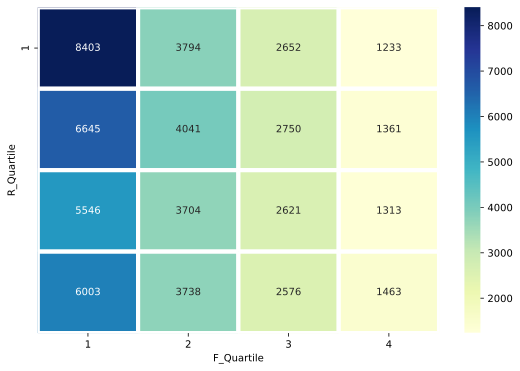

In [27]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns = 'F_Quartile',
                        values = 'M', 
                        aggfunc = np.mean).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={'size':10},yticklabels=4)

#### 2. Рассчитать максимальное количество покупок одним пользователем

In [28]:
rfmSegmentation['F'].max()

204

#### 3. Вычислить верхнюю границу у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [29]:
quantiles

,R,F,M
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


Глядя на функцию, понятно, что пользователь находится в 4 классе, если он покупает на сумму от 0 до 0.25 квантиля. В случае с monetary - это 765.

#### 4. Hижняя граница у количества покупок у пользователей с классом 1 в подсегменте F

Классом 1 в подсегменте F по функции считается класс, у которого самое большое количество покупок. В 75 квантиль подсегмента F входит и класс 2. Нижняя граница частоты его покупок 4. То есть, пользователь, который совершил 4 и более покупок, считается пользователем, попавшим в класс 1. 

In [31]:
quantiles['F'].max()

3.0

#### 5. Максимальное количество дней, которые могут пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R

По функции в класс 2 у нас попадают пользователи, которые находятся между 50 и 75 квантилями, не включая 75. От 8 до 15 дней. Верхней границей является 8 дней 

#### 6. Количество пользователей в сегменте 111

In [32]:
rfmSegmentation.query("RFM_Score == '111'").index.nunique()

9705

В самом лучшем сегменте - 9705 пользователей

#### 7. Количество пользователей в сегменте 311

In [33]:
rfmSegmentation.query("RFM_Score == '311'").index.nunique()

1609

#### 8. Вычислить в каком сегменте самое большое количество пользователей

In [35]:
rfm_1 = rfmSegmentation.reset_index()

In [36]:
rfm_1.groupby('RFM_Score', as_index=False).agg({'CustomerCode':'nunique'}).sort_values('CustomerCode', ascending=False)

,RFM_Score,CustomerCode
63,444,10624
0,111,9705
62,443,6729
47,344,6593
16,211,5847
...,...,...
55,424,63
19,214,60
3,114,60
35,314,33


Самый многочисленный сегмент - самый худший - 444

#### 9. Самое маленькое количество пользователей

Сегмент 414

#### 10. Количество пользователей в самом малочисленном сегменте

В 414 сегементе - 2 пользователя